[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Imaging-AI-for-Health-virtual-lab/SHAP-in-repeated-nested-CV/blob/main/regression_ICBM.ipynb)

# REPEATED NESTED CROSS-VALIDATION FOR REGRESSION - ICBM DATASET

In [ ]:
!git clone https://github.com/Imaging-AI-for-Health-virtual-lab/SHAP-in-repeated-nested-CV
!cd https://github.com/Imaging-AI-for-Health-virtual-lab/SHAP-in-repeated-nested-CV

In [1]:
!pip install shap
import os
import numpy as np
np.random.seed(42)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from xgboost import  XGBRegressor

from sklearn.model_selection import KFold, RandomizedSearchCV, cross_validate
from sklearn.metrics import make_scorer

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import utils as us

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import pickle
import shap


/home/riccardo/miniconda3/envs/dementia/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting variables

In [2]:

####### SETTING VARIABLES ########################
experiment_name = "ICBM"
csv_filename = "data/ICBM_data.xlsx"
dir_name = "regression_ICBM/"
os.makedirs(dir_name, exist_ok=True)
os.makedirs(dir_name + "Shap_values", exist_ok=True)
os.makedirs(dir_name + "plots", exist_ok=True)
os.makedirs(dir_name + "average_plots", exist_ok=True)
target = "Age"

num_trials = 2 # SET NUM_TRIALS = 100 FOR REPRODUCE PAPER RESULTS - about 90 min computation time
num_splits = 5
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
###########################################################################


## Reading data

In [3]:

data = pd.read_excel(csv_filename,sheet_name = experiment_name)

features = list(data.columns)

data.columns = features
if target in features: features.remove(target)
features.remove("bin_age")
print('All Data input shape:' + str(data.shape))
print('Number of input features:' + str(len(features)))


All Data input shape:(86, 11)
Number of input features:9


## Dividing data and target

In [4]:
X = data[features]
y = data[target]

## Defining variables and metrices for nested cross validation

In [5]:

train_scores = np.zeros(num_trials)
test_scores = np.zeros(num_trials)

mse_train_scores = np.zeros(num_trials)
r2_train_scores = np.zeros(num_trials)
neg_mean_absolute_error_train_scores = np.zeros(num_trials)
correlation_train_scores = np.zeros(num_trials)

mse_test_scores = np.zeros(num_trials)
r2_test_scores = np.zeros(num_trials)
neg_mean_absolute_error_test_scores = np.zeros(num_trials)
correlation_test_scores = np.zeros(num_trials)


def my_custom_loss_func(y_true, y_pred):
    return np.corrcoef(y_true,y_pred)[0][1]

score = make_scorer(my_custom_loss_func)

myscoring = {'mse': 'neg_mean_squared_error', 
        'r2': 'r2',
        'neg_mean_absolute_error':'neg_mean_absolute_error',
        'correlation' : score
        }

## Model setting

In [6]:

######## MODEL SETTING ##############################
param_grid = {
			"regressor__gamma":[0.6,0.7,0.8],
			"regressor__colsample_bytree" : [0.25,0.5,0.75,1],
			"regressor__max_depth": [2,3,4],
			"regressor__min_child_weight" : [2,3,5],
			"regressor__n_estimators":[5,10, 20, 100],
			"regressor__subsample": [0.1,0.2,0.4],
			}
model = XGBRegressor(verbosity=0)
#####################################################


## Start of repeated nested CV

In [10]:
shap.initjs()
for i in range(num_trials):

    print("Iteration:" + str(i))

    inner_cv = KFold(n_splits=num_splits, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=num_splits, shuffle=True, random_state=i)

    pipe = Pipeline(steps=[('imputer', imputer),  ('scaler', scaler), ('regressor', model)])
    clf = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=100, scoring=score, refit=True, cv=inner_cv, verbose=0,  random_state=i, return_train_score=True)

    # Take a look at the best params

    nested_score = cross_validate(clf, X=X, y=y, cv=outer_cv, return_train_score=True, error_score="raise",return_estimator=True, scoring = myscoring)


    mse_test_scores[i] = np.mean(nested_score['test_mse'])
    r2_test_scores[i] = np.mean(nested_score['test_r2'])
    neg_mean_absolute_error_test_scores[i] = np.mean(nested_score['test_neg_mean_absolute_error'])
    correlation_test_scores[i] = np.mean(nested_score['test_correlation'])

    print('mse ' + str(mse_test_scores[i]))
    print('r2 ' + str(r2_test_scores[i]))
    print('neg_mean_absolute_error ' + str(neg_mean_absolute_error_test_scores[i]))
    print('correlation ' + str(correlation_test_scores[i]))


    ############# SHAP VALUES COMPUTATION FOR EACH FOLD ##################
    iter_shap = 0
    indices = []

    for train_index, test_index in inner_cv.split(X, y):
        #print("Split:", iter_shap)
        ## TRUE POSITIVE RATE COMPUTATION FOR EACH OUTER LOOP (TEST SET)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train = pd.DataFrame(X_train,columns=features)
        X_test = pd.DataFrame(X_test,columns=features)
        y_train = pd.DataFrame(y_train, columns=[target])


        regressor_shap = nested_score['estimator'][iter_shap].best_estimator_["regressor"]

        pipe = Pipeline(steps=[('imputer', imputer),  ('scaler', scaler),('regressor', regressor_shap)])
        pipe.fit(X_train, y_train)

        ###################################################
        y_pred = pipe.predict(X_test)

        ############## SHAP VALUES ################

        model = pipe.named_steps["regressor"]
        ### TRAINING DATA
        train_tmp_df = pd.DataFrame(scaler.fit_transform(imputer.fit_transform(X_train)), columns = features)
        explainer = shap.TreeExplainer(model, train_tmp_df)
        
        ### TEST DATA
        test_tmp_df = pd.DataFrame(scaler.fit_transform(imputer.fit_transform(X_test)), columns = features)
        test_explainer = shap.TreeExplainer(model, test_tmp_df)

        #########################################################
        
        plt.figure()
        shap.summary_plot(explainer.shap_values(train_tmp_df),train_tmp_df, show=False)
        plt.savefig(dir_name + '/plots/train_summary_plot_shap_'+str(i)+'_'+str(iter_shap)+'.png',  bbox_inches = 'tight')
        plt.close()
        plt.figure()
        shap.summary_plot(test_explainer.shap_values(test_tmp_df),test_tmp_df, show=False)
        plt.savefig(dir_name + '/plots/test_summary_plot_shap_'+str(i)+'_'+str(iter_shap)+'.png', bbox_inches = 'tight')
        plt.close()

        plt.figure()
        shap.summary_plot(explainer.shap_values(train_tmp_df),train_tmp_df,plot_type="bar", show=False)
        plt.savefig(dir_name +'/plots/train_summary_bar_plot_shap_'+str(i)+'_'+str(iter_shap)+'.png', bbox_inches = 'tight')
        plt.close()
        plt.figure()
        shap.summary_plot(test_explainer.shap_values(test_tmp_df),test_tmp_df, plot_type="bar",show=False)
        plt.savefig(dir_name +'/plots/test_summary_bar_plot_shap_'+str(i)+'_'+str(iter_shap)+'.png', bbox_inches = 'tight')
        plt.close()


        df_shap = pd.DataFrame(explainer.shap_values(train_tmp_df),columns=features)
        df_shap["index"] = train_index
        pickle.dump(df_shap, open(dir_name + '/Shap_values/' + 'train'+str(i) + 'fold' + str(iter_shap) + '.pkl','wb'))

        test_df_shap= pd.DataFrame(explainer.shap_values(test_tmp_df),columns=features)
        test_df_shap["index"] = test_index
        pickle.dump(test_df_shap, open(dir_name + '/Shap_values/' + 'test'+str(i) + 'fold' + str(iter_shap) + '.pkl','wb'))

        iter_shap += 1
    #######################################################################

########################################################################

quantities = {}
quantities_names = ["test_mse","test_r2","test_neg_mean_absolute_error","test_correlation"]
for i, j in zip(quantities_names,[test_scores,r2_test_scores,neg_mean_absolute_error_test_scores,correlation_test_scores]):
    quantities[i] = us.mean_std(j)
print('*** Average performance')

for i in quantities.keys():
    print(i + "(mean " + str(quantities[i][0])+ ", std "+ str(quantities[i][1])+ ")")



Iteration:0
mse -241.6612947933135
r2 0.2110243148025114
neg_mean_absolute_error -12.168185489629609
correlation 0.6492734467953666
Iteration:1
mse -231.01413599954512
r2 0.26470970281069517
neg_mean_absolute_error -11.976021730510238
correlation 0.5875126659750841
*** Average performance
test_mse(mean 0.0, std 0.0)
test_r2(mean 0.23786700880660328, std 0.02684269400409188)
test_neg_mean_absolute_error(mean -12.072103610069924, std 0.09608187955968539)
test_correlation(mean 0.6183930563852253, std 0.030880390410141234)


# AVERAGE SHAP VALUES FOR TRAIN AND TEST

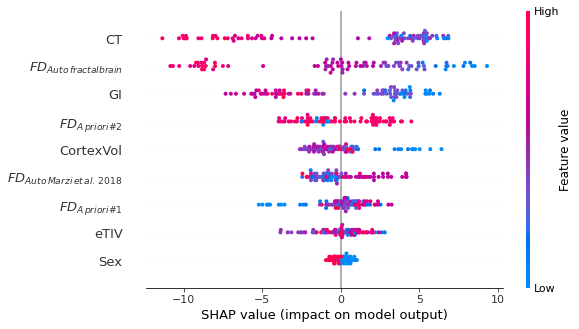

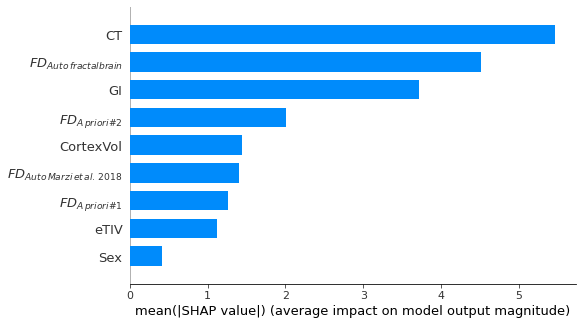

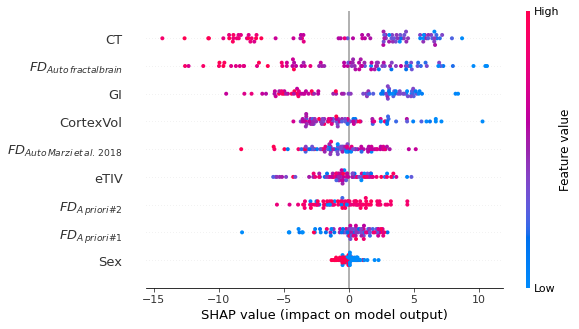

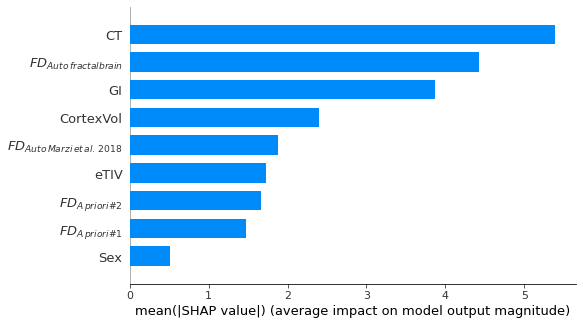

In [7]:

us.average_shap_values(dir_name,data[features], num_trials,num_splits)